In [1]:
%pylab nbagg

from tvb.simulator.lab import *

import numpy as np
import time as tm 

Populating the interactive namespace from numpy and matplotlib
   INFO  NumExpr defaulting to 3 threads.
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'y1': array([-20.,   2.]), 'z': array([2., 5.]), 'x2': array([-2.,  0.]), 'y2': array([0., 2.]), 'g': array([-1.,  1.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.epileptor.Epileptor2D.tt = NArray(label='tt', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor2D.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'z': array([2., 5.])}, required=True)
WARNING 

WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.stefanescu_jirsa.ReducedSetFitzHughNagumo.state_variable_range = Final(field_type=<class 'dict'>, default={'xi': array([-4.,  4.]), 'eta': array([-3.,  3.]), 'alpha': array([-4.,  4.]), 'beta': array([-3.,  3.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.a = NArray(label=':math:`a`', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 3.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.b = NArray(label=':math:`b`', dtype=float64, default=array([3.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindma

# Reduction 2-dimentional Epileptor model

***

The **Epileptor 2D** model is the reduction of the 5 dimensions Epileptor model to only 2 dimensions, by applying averaging methods (see **Proix et al., 2014**). Then, the Epileptor equations become :

\begin{eqnarray}
    \dot{x}_{1,i} &=& - x_{1,i}^{3} - 2x_{1,i}^{2} + 1 + I_{ext_{1}}\\
    \dot{z}_{i} &=& \dfrac{1}{\tau_{0}} \ (4(x_{1,i} - x_{0, i}) - z_{i} - K{s}\sum_{j=1}^{N}C_{ij}(x_{1,j} - x_{1,i})))
\end{eqnarray}

where $\tau_{0}=2857$, $I_{ext_{1}}=3.1$, and the degree of epileptogenicity is represented through the value $x_{0}$. $C_{ij}$ are the entries of the anatomical structural connectivity matrix reweigthed by the global coupling parameter $K_{s}$.

## 1. Exploring the Epileptor 2D model

Before launching any simulations, we will have a look at the **phase space** of the model in order to better understand its dynamics. We will use the phase plane interactive tool.

We plot the two nullclines that are defined as zero flux in either the $x_{1}$ or $z$ direction: the linear nullcline in green and the cubic nullcline in red. The intersections of the nullclines identify the fixed points of the system. The **interictal state** and the **ictal state** correspond to the **left** and the **right** branches of the cubic nullcline, respectively.

Have a look to the phase space for the **2D system** (Fig. 8C in Proix et al. 2014):

<IPython.core.display.Javascript object>


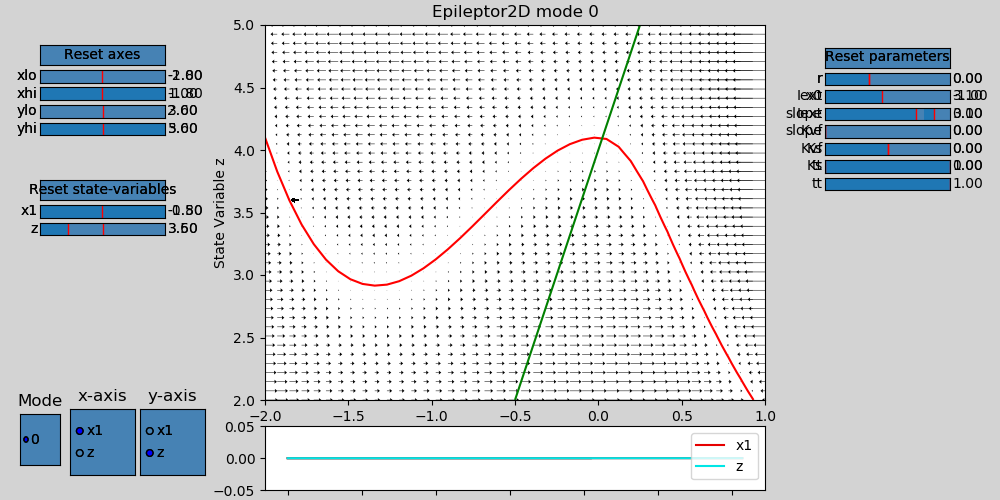

In [2]:
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive

# Create an Epileptor model instance.
epi = models.epileptor.Epileptor2D(x0=numpy.array([-1]))

# Initialise a stochastic Integrator scheme.
dt = 0.5                                           #integration steps [ms]
heundetint = integrators.HeunDeterministic(dt=dt)
#heunstochint = integrators.HeunStochastic(dt=dt)
#heunstochint.noise.nsig = 0.01                      #standard deviation of the noise 

# Open the phase plane tool with the Epileptor model and (stochastic) Integrator.
ppi_fig = PhasePlaneInteractive(model=epi, integrator=heundetint)
ppi_fig.show()

According to the value of the parameter $\pmb{x_{0}}$, the linear nullcline (green curve) moves left and right, changing the stability of the fixed point. Two typical trajectories are possible:

- For $\pmb{x_{0} < -2.05}$, the trajectory is attracted to the **stable fixed point** in the interictal state on the left cubic nullcline and the Epileptor is said **not epileptogenic**, meaning not triggering epileptic seizure without external input.

- For $\pmb{x_{0} > -2.05}$, the stable point disappears through a Hopf bifurcation, and there is only **one unstable fixed point** left. The Epileptor enters an **oscillatory regime** and the Epileptor is said to be **epileptogenic**, triggering seizures autonomously.



## 2. Comparison with complete 5D Epileptor


In order to compare the results obtained from the complete and reduced system, we will model a patient with a temporal lobe epilepsy (TLE).

To this end, we define a spatial map of epileptogenicity where each network's node $i$ is characterized by an excitability value  $x_{0,i}$, which quantifies its ability to trigger a seizure. 

We set:

- the right limbic areas (right hippocampus (rHC, region 47), parahippocampus (rPHC, region 62) and amygdala (rAMYG, region 40)) as **Epileptic Zone (EZ)** with an epileptogenicity parameter value equal to **- 1.6**,
- and two lesser epileptogenic regions: the inferior temporal cortex (rTCI, region 69) and the ventral temporal cortex (rTCV, region 72) as **Propagation Zone (PZ)**, with an epileptogenicity parameter value equal to **- 1.8**,
- and all the other regions (or **Non-Epileptogenic Zone, NEZ**) are set to -2.4.


In [3]:
# Initialise a Connectivity.
con = connectivity.Connectivity.from_file()
N = con.weights.shape[0]
con.weights - con.weights * np.eye(N, N)
con.weights = con.weights / np.abs(con.weights.max())
con.tract_lengths = np.zeros((con.tract_lengths.shape))             # no time-delays 
con.configure()

WARNING  File 'hemispheres' not found in ZIP.


In [4]:
# Initialise the complete model.
Epileptor5D = models.epileptor.Epileptor(Ks=numpy.array([1]), r=numpy.array([0.00015]))
Epileptor5D.x0 = np.ones((76))*-2.4                #NEZ
Epileptor5D.x0[[62, 47, 40]] = np.ones((3))*-1.6   #EZ
Epileptor5D.x0[[69, 72]] = np.ones((2))*-1.8       #PZ

#Initial conditions.
Epileptor5D.state_variable_range["x1"] = numpy.array([-1.8, -1.8])
Epileptor5D.state_variable_range["y1"] = numpy.array([-15, -15])
Epileptor5D.state_variable_range["x2"] = numpy.array([-1, -1])
Epileptor5D.state_variable_range["y2"] = numpy.array([0.01, 0.01])
Epileptor5D.state_variable_range["z"] = numpy.array([3.6, 3.6])

Epileptor5D.variables_of_interest = ['x2 - x1', 'x1', 'z']

In [5]:
# Initialise Simulator.
sim = simulator.Simulator(model=Epileptor5D, 
                          connectivity=con,
                          coupling=coupling.Difference(a=numpy.array([-0.2])), 
                          integrator=integrators.HeunDeterministic(dt=0.05), 
                          monitors=(monitors.TemporalAverage(period=1.),))

sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 3c261bf6-d7c7-48ad-809e-23214c1ee110
coupling,Difference gid: 83cd23a5-398b-4151-888f-45eeb7399740
gid,UUID('2832c298-5f2f-45ff-903c-b96ce3ed8cb2')
initial_conditions,None
integrator,HeunDeterministic gid: bd8d3a36-9566-4e25-b925-40d0b4e16868
model,Epileptor gid: e344e708-1070-4ff2-ae2d-6e3266943e00
monitors,"(,)"
simulation_length,1000.0


In [6]:
print("Starting simulation...")
tic = tm.time()
(t, y), = sim.run(simulation_length=10000)
print("Finished simulation.")
print('execute for ' + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for 65.75263929367065


In [7]:
# Initialise the reduced model.
Epileptor2D = models.epileptor.Epileptor2D(Ks=numpy.array([1]), r=numpy.array([0.00015]))
Epileptor2D.x0 = np.ones((76))*-2.4               #NEZ
Epileptor2D.x0[[62, 47, 40]] = np.ones((3))*-1.6  #EZ
Epileptor2D.x0[[69, 72]] = np.ones((2))*-1.8      #PZ

#Initial conditions.
Epileptor2D.state_variable_range["x1"] = numpy.array([-1.8, -1.8])
Epileptor2D.state_variable_range["z"] = numpy.array([3.6, 3.6])

In [8]:
# Initialise Simulator.
sim = simulator.Simulator(model=Epileptor2D, 
                          connectivity=con,
                          coupling=coupling.Difference(a=numpy.array([-0.2])), 
                          integrator=integrators.HeunDeterministic(dt=0.05), 
                          monitors=(monitors.TemporalAverage(period=1.),))

sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 3c261bf6-d7c7-48ad-809e-23214c1ee110
coupling,Difference gid: a06835e1-33e6-4daa-901d-aeddeb41c509
gid,UUID('9f16f3e6-47bc-40cb-8d8e-d8b79dbb18a5')
initial_conditions,None
integrator,HeunDeterministic gid: e71dac26-0761-4f65-aab8-2254a877022b
model,Epileptor2D gid: 3a23f15c-4f52-4568-8660-28d08246ebf5
monitors,"(,)"
simulation_length,1000.0


In [9]:
print("Starting simulation...")
tic = tm.time()
(s, z), = sim.run(simulation_length=10000)
print("Finished simulation.")
print('execute for ' + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for 50.58949375152588


In [10]:
# Normalize the time series to have nice plots
y /= (np.max(y, 0) - np.min(y, 0))
y -= np.mean(y, 0)
z /= (np.max(z, 0) - np.min(z, 0))
z -= np.mean(z, 0)

<IPython.core.display.Javascript object>


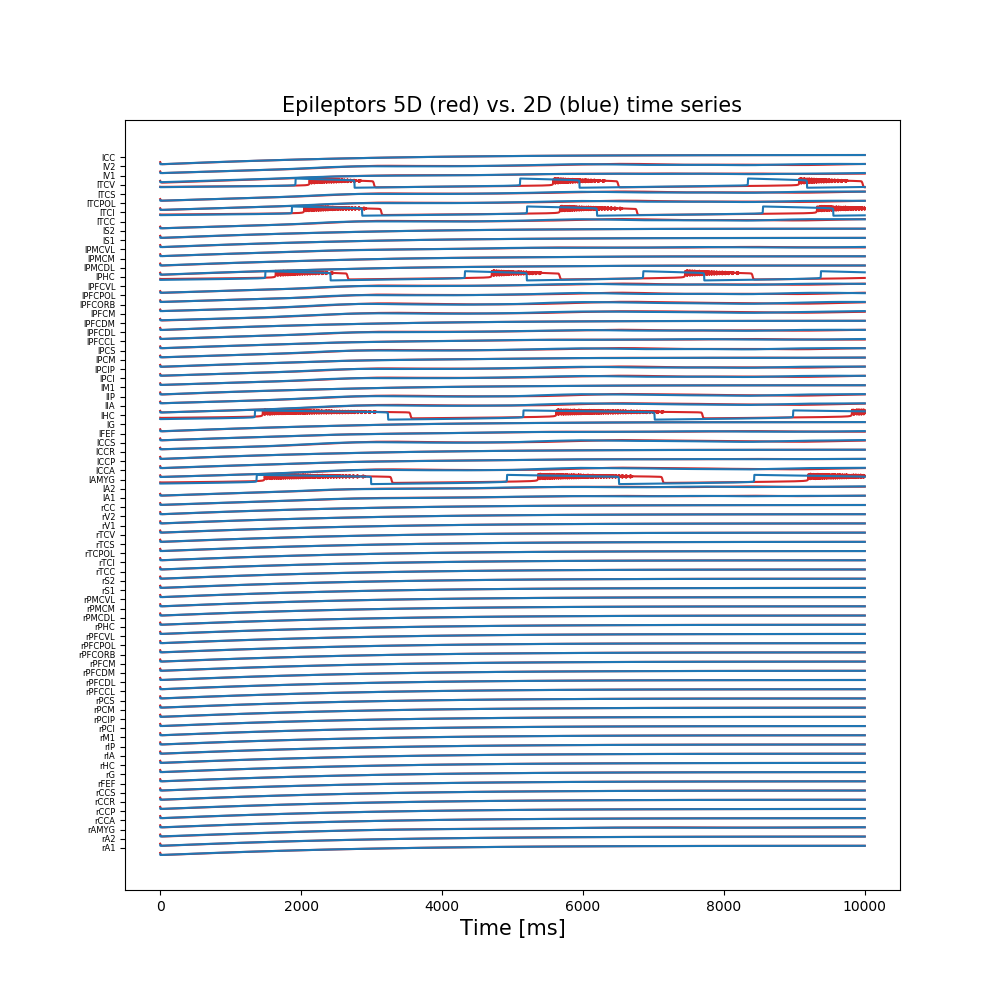

In [11]:
# Plot time series
figure(figsize=(10,10))
plot(t[:], y[:, 1, :, 0] + np.r_[:76], 'C3')
plot(s[:], z[:, 0, :, 0] + np.r_[:76], 'C0')
title("Epileptors 5D (red) vs. 2D (blue) time series", fontsize=15)
xlabel('Time [ms]', fontsize=15)
yticks(np.arange(len(sim.connectivity.region_labels)), sim.connectivity.region_labels, fontsize=6)
show()

Both systems show **good correspondance** with slight differences in the intrinsic frequencies.

## 3. Modification of the slow permittivity variable $z$ dynamics

The duration of the ictal and interictal state is approximately the same in the Epileptor, which is not the case in clinical situations, where the **interictal period** is typically **longer**. To this end, we use a **slight modification** of the Epileptor equations and replace the linear influence of $x_{1}$ on the slow permittivity variable $z$ by the **nonlinear function** $\pmb{h}$ causing a symmetry breaking between ictal and interictal period with an increase of the latter. The Epileptor equations with the here used modification read then as follows:

\begin{eqnarray}
    \dot{x}_{1,i} &=& - x_{1,i}^{3} - 2x_{1,i}^{2} + 1 + I_{ext_{1}}\\
    \dot{z}_{i} &=& \dfrac{1}{\tau_{0}} \ (h(x_{1,i}) - z_{i} - K{s}\sum_{j=1}^{N}C_{ij}(x_{1,j} - x_{1,i})))
\end{eqnarray}

where

\begin{eqnarray}
    h(x_{1,i}) = x_{0,i} + 3. \ / \left(1 + \exp\left(\dfrac{-x_{1,i} - 0.5}{0.1}\right)\right)
\end{eqnarray}

First, we have a look to the phase space of the **2D system** for the **modified Epileptor** equations (see Fig. 8B in Proix et al., 2014).

In [12]:
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive

# Create an Epileptor model instance.
epim = models.epileptor.Epileptor2D(x0=numpy.array([2]), modification=numpy.array([True]))
# Initialise a stochastic Integrator scheme.
dt = 0.75                                           #integration steps [ms]
heundetint = integrators.HeunDeterministic(dt=dt)
#heunstochint = integrators.HeunStochastic(dt=dt)
#heunstochint.noise.nsig = 0.01                      #standard deviation of the noise 

# Open the phase plane tool with the Epileptor model and (stochastic) Integrator.
ppi_fig = PhasePlaneInteractive(model=epim, integrator=heundetint, exclude_sliders=["x0"])
ppi_fig.show()

/root/tvb-root/scientific_library/tvb/simulator/plot/phase_plane_interactive.py:260: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.pp_ax = self.ipp_fig.add_axes([0.265, 0.2, 0.5, 0.75])
/root/tvb-root/scientific_library/tvb/simulator/plot/phase_plane_interactive.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.pp_splt = self.ipp_fig.add_subplot(212)
/root/tvb-root/scientific_library/tvb/simulator/plot/phase_plane_

According to the value of the parameter $\pmb{x_{0}}$, the sigmoid nullcline (green curve) moves up and down, changing the number and stability of the fixed points. Two typical trajectories are possible:

- For $\pmb{x_{0} > 2.91}$, the trajectory is attracted to the **stable fixed point** in the interictal state on the left cubic nullcline and the Epileptor is said **not epileptogenic**, meaning not triggering epileptic seizure without external input.
- For $\pmb{x_{0} < 2.91}$, the two left most fixed points disappear through a SNIC bifurcation, and there is only **one unstable fixed point** left. The Epileptor enters an **oscillatory regime** and the Epileptor is said to be **epileptogenic**, triggering seizures autonomously.



In [13]:
# Initialise the Model.
Epileptormod = models.epileptor.Epileptor2D(Ks=numpy.array([1.]), r=numpy.array([0.00025]), modification=numpy.array([True]))
Epileptormod.x0 = np.ones((76)) * 3.5
Epileptormod.x0[[62, 47, 40]] = np.ones((3)) * 2.
Epileptormod.x0[[69, 72]] = np.ones((2)) * 2.3

Epileptormod.state_variable_range["x1"] = numpy.array([-1.8, -1.8])
Epileptormod.state_variable_range["z"] = numpy.array([3.6, 3.6])

In [14]:
sim = simulator.Simulator(model=Epileptormod, 
                          connectivity=con,
                          coupling=coupling.Difference(a=numpy.array([-0.2])), 
                          integrator=integrators.HeunDeterministic(dt=0.05), 
                          monitors=(monitors.TemporalAverage(period=1.),))

sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 3c261bf6-d7c7-48ad-809e-23214c1ee110
coupling,Difference gid: 99d26910-91fc-44bb-bb8d-64ac59ce16b3
gid,UUID('1248b61f-6460-451e-b99c-f4e14658fb1f')
initial_conditions,None
integrator,HeunDeterministic gid: aa08530a-bea4-45a8-b36e-71cee0a94767
model,Epileptor2D gid: a8d31cd8-7287-4953-8576-6965a91eb21c
monitors,"(,)"
simulation_length,1000.0


In [15]:
print("Starting simulation...")
tic = tm.time()
(s_, z_),  = sim.run(simulation_length=10000)
print("Finished simulation.")
print('execute for' + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for58.355324506759644


In [16]:
# Normalize the time series to have nice plots
z_ /= (np.max(z_,0) - np.min(z_,0 ))
z_ -= np.mean(z_, 0)

<IPython.core.display.Javascript object>


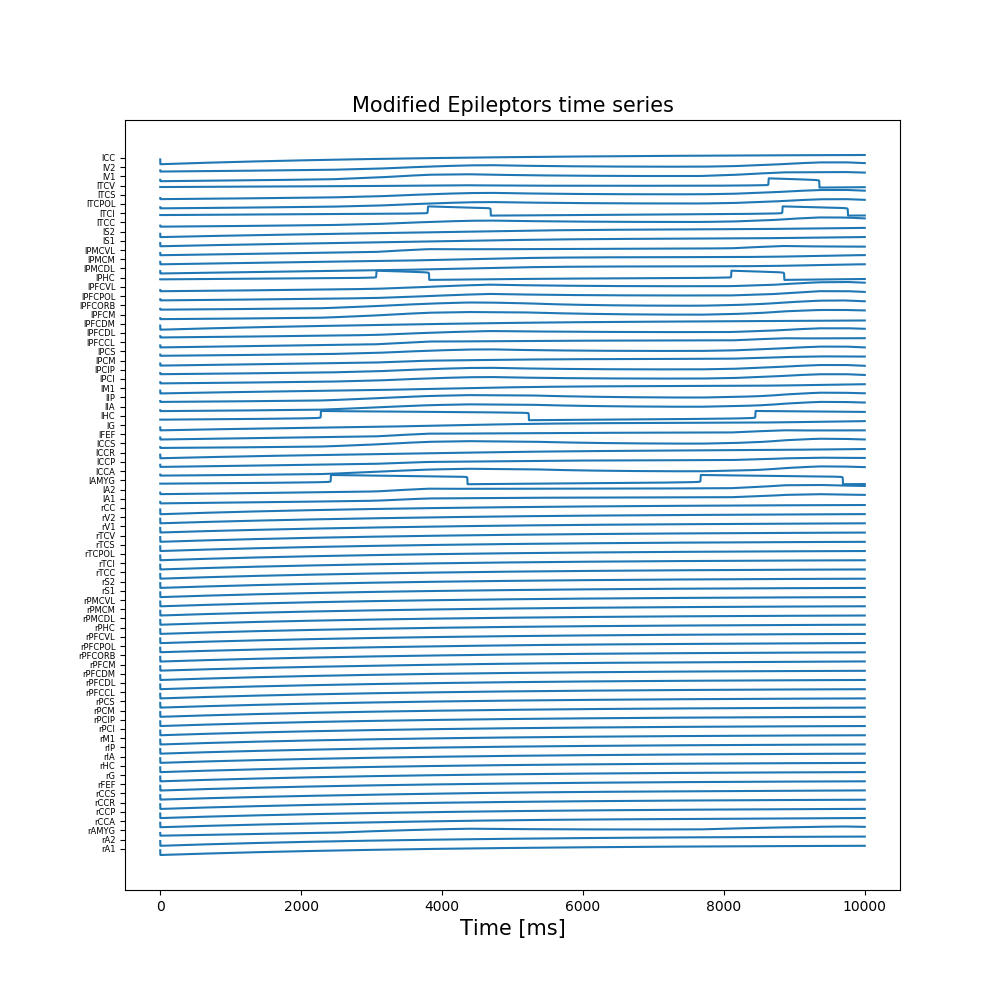

In [17]:
# Plot time series
figure(figsize=(10,10))
#plot(s[:], z[:, 0, :, 0] + np.r_[:76], 'C4')
plot(s_[:], z_[:, 0, :, 0] + np.r_[:76], 'C0')
title("Modified Epileptors time series", fontsize=15)
xlabel('Time [ms]', fontsize=15)
yticks(np.arange(len(sim.connectivity.region_labels)), sim.connectivity.region_labels, fontsize=6)
show()